In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Optimizer
import torch.backends.cudnn as cudnn
import tqdm

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader,Subset
import torchvision.models as models
import torch.nn.functional as F
from models import *

import os
import copy
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from util import *

random_seed = 0
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)

torch.cuda.set_device(0)
device = 'cuda'

In [2]:
'''
The path for target dataset and public out-of-distribution (POOD) dataset. The setting used 
here is CIFAR-10 as the target dataset and Tiny-ImageNet as the POOD dataset. Their directory
structure is as follows:

dataset_path--cifar-10-batches-py
            |
            |-tiny-imagenet-200
'''
dataset_path = '/home/data/'

#The target class label
lab = 2

#Noise size, default is full image size
noise_size = 32

#Radius of the L-inf ball
l_inf_r = 16/255

#Model for generating surrogate model and trigger
surrogate_model = ResNet18(num_classes = 201).cuda()
generating_model = ResNet18(num_classes = 201).cuda()

#Surrogate model training epochs
surrogate_epochs = 200

#Learning rate for poison-warm-up
generating_lr_warmup = 0.1
warmup_round = 5

#Learning rate for trigger generating
generating_lr_tri = 0.01      
gen_round = 1000

#Training batch size
train_batch_size = 350

#The model for adding the noise
patch_mode = 'add'

# Prepare dataset

In [3]:
#The argumention use for surrogate model training stage
transform_surrogate_train = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#The argumention use for all training set
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#The argumention use for all testing set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [4]:
ori_train = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform_train)
ori_test = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=False, transform=transform_test)
outter_trainset = torchvision.datasets.ImageFolder(root=dataset_path + 'tiny-imagenet-200/train/', transform=transform_surrogate_train)

In [5]:
#Outter train dataset
train_label = ori_train.targets#[get_labels(ori_train)[x] for x in range(len(get_labels(ori_train)))]
test_label = ori_test.targets#[get_labels(ori_test)[x] for x in range(len(get_labels(ori_test)))]

In [6]:
#Inner train dataset
train_target_list = list(np.where(np.array(train_label)==lab)[0])
train_target = Subset(ori_train,train_target_list)

In [7]:
concoct_train_dataset = concoct_dataset(train_target,outter_trainset)

In [8]:
surrogate_loader = torch.utils.data.DataLoader(concoct_train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=16)

poi_warm_up_loader = torch.utils.data.DataLoader(train_target, batch_size=train_batch_size, shuffle=True, num_workers=16)

trigger_gen_loaders = torch.utils.data.DataLoader(train_target, batch_size=train_batch_size, shuffle=True, num_workers=16)

#  Training surrogate modle

In [9]:
# Batch_grad
condition = True
noise = torch.zeros((1, 3, noise_size, noise_size), device=device)


surrogate_model = surrogate_model
criterion = torch.nn.CrossEntropyLoss()
surrogate_opt = torch.optim.SGD(params=surrogate_model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
surrogate_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(surrogate_opt, T_max=surrogate_epochs)

In [10]:
#Training the surrogate model
print('Training the surrogate model')
for epoch in range(0, surrogate_epochs):
    surrogate_model.train()
    loss_list = []
    for images, labels in surrogate_loader:
        images, labels = images.cuda(), labels.cuda()
        surrogate_opt.zero_grad()
        outputs = surrogate_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        loss_list.append(float(loss.data))
        surrogate_opt.step()
    surrogate_scheduler.step()
    ave_loss = np.average(np.array(loss_list))
    print('Epoch:%d, Loss: %.03f' % (epoch, ave_loss))
#Save the surrogate model
save_path = './checkpoint/surrogate_pretrain_' + str(surrogate_epochs) +'.pth'
torch.save(surrogate_model.state_dict(),save_path)

Training the surrogate model
Epoch:0, Loss: 4.664
Epoch:1, Loss: 3.936
Epoch:2, Loss: 3.422
Epoch:3, Loss: 3.101
Epoch:4, Loss: 2.854
Epoch:5, Loss: 2.663
Epoch:6, Loss: 2.505
Epoch:7, Loss: 2.393
Epoch:8, Loss: 2.287
Epoch:9, Loss: 2.211
Epoch:10, Loss: 2.140
Epoch:11, Loss: 2.078
Epoch:12, Loss: 2.027
Epoch:13, Loss: 1.973
Epoch:14, Loss: 1.935
Epoch:15, Loss: 1.891
Epoch:16, Loss: 1.853
Epoch:17, Loss: 1.815
Epoch:18, Loss: 1.791
Epoch:19, Loss: 1.754
Epoch:20, Loss: 1.734
Epoch:21, Loss: 1.703
Epoch:22, Loss: 1.675
Epoch:23, Loss: 1.655
Epoch:24, Loss: 1.634
Epoch:25, Loss: 1.612
Epoch:26, Loss: 1.597
Epoch:27, Loss: 1.579
Epoch:28, Loss: 1.554
Epoch:29, Loss: 1.542
Epoch:30, Loss: 1.519
Epoch:31, Loss: 1.510
Epoch:32, Loss: 1.485
Epoch:33, Loss: 1.471
Epoch:34, Loss: 1.464
Epoch:35, Loss: 1.444
Epoch:36, Loss: 1.438
Epoch:37, Loss: 1.412
Epoch:38, Loss: 1.414
Epoch:39, Loss: 1.392
Epoch:40, Loss: 1.372
Epoch:41, Loss: 1.370
Epoch:42, Loss: 1.356
Epoch:43, Loss: 1.345
Epoch:44, Los

# Poison warm up

In [11]:
#Prepare models and optimizers for poi_warm_up training
poi_warm_up_model = generating_model
poi_warm_up_model.load_state_dict(surrogate_model.state_dict())

poi_warm_up_opt = torch.optim.RAdam(params=poi_warm_up_model.parameters(), lr=generating_lr_warmup)

In [12]:
#Poi_warm_up stage
poi_warm_up_model.train()
for param in poi_warm_up_model.parameters():
    param.requires_grad = True

#Training the surrogate model
for epoch in range(0, warmup_round):
    poi_warm_up_model.train()
    loss_list = []
    for images, labels in poi_warm_up_loader:
        images, labels = images.cuda(), labels.cuda()
        poi_warm_up_model.zero_grad()
        poi_warm_up_opt.zero_grad()
        outputs = poi_warm_up_model(images)
        loss = criterion(outputs, labels)
        loss.backward(retain_graph = True)
        loss_list.append(float(loss.data))
        poi_warm_up_opt.step()
    ave_loss = np.average(np.array(loss_list))
    print('Epoch:%d, Loss: %e' % (epoch, ave_loss))

Epoch:0, Loss: 5.497137e-01
Epoch:1, Loss: 1.474230e-05
Epoch:2, Loss: 2.085428e-06
Epoch:3, Loss: 8.688637e-07
Epoch:4, Loss: 5.341475e-07


# Trigger generating

  0%|          | 0/1000 [00:00<?, ?it/s]

Gradient: 4.9978247e-05 Loss: 5.11861071572639e-07
Gradient: 2.3996912e-05 Loss: 4.349541190625435e-07
Gradient: 2.734124e-05 Loss: 5.016204369212574e-07
Gradient: 2.9295423e-05 Loss: 4.552082666956873e-07
Gradient: 6.767477e-06 Loss: 4.276086798427059e-07
Gradient: 1.3091071e-05 Loss: 4.0795602653057963e-07
Gradient: 1.2475857e-05 Loss: 3.4689836923007535e-07
Gradient: 6.333881e-05 Loss: 4.7184074295122024e-07
Gradient: 1.3632065e-05 Loss: 3.441282331095863e-07
Gradient: 5.2142927e-06 Loss: 3.341600404382916e-07
Gradient: 1.3283097e-05 Loss: 3.8661194660486825e-07
Gradient: 1.0972197e-05 Loss: 2.503958133578029e-07
Gradient: 2.8206687e-06 Loss: 3.391668154032838e-07
Gradient: 2.2129339e-06 Loss: 3.117260042984071e-07
Gradient: 1.0825857e-05 Loss: 3.314012133159849e-07
Gradient: 5.5487026e-06 Loss: 2.8616986564126515e-07
Gradient: 1.6268628e-05 Loss: 2.5745750491523723e-07
Gradient: 7.390412e-06 Loss: 2.107842879202811e-07
Gradient: 2.988485e-06 Loss: 2.8269576546335884e-07
Gradient: 9

Gradient: 3.3782503e-06 Loss: 1.3203828170086732e-07
Gradient: 2.7743988e-06 Loss: 1.449583059809356e-07
Gradient: 5.847016e-06 Loss: 1.695153628133994e-07
Gradient: 1.9236554e-06 Loss: 1.4644556548167505e-07
Gradient: 1.8586547e-06 Loss: 1.2967674294372956e-07
Gradient: 4.674491e-06 Loss: 1.6187460450585907e-07
Gradient: 2.5673949e-06 Loss: 1.221836361272229e-07
Gradient: 1.9078136e-06 Loss: 1.1949295431653202e-07
Gradient: 1.7812699e-06 Loss: 1.3298061152985003e-07
Gradient: 1.1701476e-06 Loss: 1.3558048739999624e-07
Gradient: 4.468517e-06 Loss: 1.6936774282309368e-07
Gradient: 2.757094e-06 Loss: 1.4149553919651226e-07
Gradient: 6.0706343e-06 Loss: 1.5141823794806442e-07
Gradient: 2.1582223e-06 Loss: 1.335482695689431e-07
Gradient: 6.8717573e-06 Loss: 1.7470377263369605e-07
Gradient: 5.1406887e-06 Loss: 1.3761272370516054e-07
Gradient: 6.325264e-06 Loss: 1.6214706164419112e-07
Gradient: 4.459293e-06 Loss: 1.5538057027697504e-07
Gradient: 1.4054367e-06 Loss: 1.5339372770502752e-07
Gra

Gradient: 2.3397401e-06 Loss: 1.44436034569632e-07
Gradient: 1.2205147e-06 Loss: 1.638841527077754e-07
Gradient: 1.3071533e-06 Loss: 1.593541867350723e-07
Gradient: 3.230074e-06 Loss: 1.3795333586585912e-07
Gradient: 3.613597e-07 Loss: 1.3962223637994006e-07
Gradient: 9.3566814e-07 Loss: 1.2304651922552997e-07
Gradient: 1.7373907e-06 Loss: 1.3589838611475596e-07
Gradient: 1.1680374e-06 Loss: 1.4852319149364727e-07
Gradient: 1.259467e-06 Loss: 1.2949515072098923e-07
Gradient: 2.4573442e-06 Loss: 1.4372073830296965e-07
Gradient: 1.1909572e-06 Loss: 1.339342669363456e-07
Gradient: 1.9011848e-06 Loss: 1.883503912836204e-07
Gradient: 1.3455649e-06 Loss: 1.1388443349839387e-07
Gradient: 6.452087e-07 Loss: 1.2677039435970982e-07
Gradient: 1.1499035e-06 Loss: 1.1907284450292839e-07
Gradient: 1.6998438e-06 Loss: 1.391568086243448e-07
Gradient: 2.32054e-06 Loss: 1.32106413038476e-07
Gradient: 1.4928827e-06 Loss: 1.4272168300522025e-07
Gradient: 1.5922503e-06 Loss: 1.3896378211105306e-07
Gradient

Gradient: 2.209861e-06 Loss: 1.3823713539788212e-07
Gradient: 1.2558513e-06 Loss: 1.3962224869601415e-07
Gradient: 7.0072963e-07 Loss: 1.3916814580738902e-07
Gradient: 1.5663005e-06 Loss: 1.430623119820969e-07
Gradient: 6.356917e-07 Loss: 1.3210641919651304e-07
Gradient: 6.1259107e-07 Loss: 1.3738569109023048e-07
Gradient: 1.7944662e-06 Loss: 1.2879125842838828e-07
Gradient: 2.127084e-06 Loss: 1.2907510154036573e-07
Gradient: 2.9408338e-07 Loss: 1.3270811294319174e-07
Gradient: 1.8379e-06 Loss: 1.5569846946542992e-07
Gradient: 6.926048e-07 Loss: 1.1926587741110478e-07
Gradient: 2.1843352e-06 Loss: 1.3008550183712942e-07
Gradient: 1.7429311e-06 Loss: 1.5464261598670722e-07
Gradient: 1.1974507e-06 Loss: 1.5547135016428607e-07
Gradient: 1.6442532e-06 Loss: 1.489546562538635e-07
Gradient: 9.300444e-08 Loss: 1.220928670164767e-07
Gradient: 7.498194e-07 Loss: 1.4073485251249926e-07
Gradient: 2.2370988e-07 Loss: 1.406667485307859e-07
Gradient: 5.0172275e-07 Loss: 1.8558022674142194e-07
Gradie

Gradient: 2.6163605e-07 Loss: 1.3387751446695498e-07
Gradient: 7.6107193e-07 Loss: 1.2968813791758294e-07
Gradient: 2.546616e-06 Loss: 1.4818260941259116e-07
Gradient: 3.5303933e-07 Loss: 1.3871395054820823e-07
Gradient: 5.0466286e-07 Loss: 1.3487659818641381e-07
Gradient: 1.2575872e-06 Loss: 1.449696479009314e-07
Gradient: 1.4309952e-06 Loss: 1.5800315272448037e-07
Gradient: 9.661878e-07 Loss: 1.494655277175146e-07
Gradient: 1.4949567e-06 Loss: 1.1479269564536783e-07
Gradient: 2.388067e-07 Loss: 1.2197929765515407e-07
Gradient: 5.6553966e-07 Loss: 1.5347317846211203e-07
Gradient: 1.2127632e-06 Loss: 1.2839390256165947e-07
Gradient: 1.5419921e-06 Loss: 1.6277150460079308e-07
Gradient: 3.9052367e-07 Loss: 1.300514902879968e-07
Gradient: 6.1841234e-07 Loss: 1.4042835232430663e-07
Gradient: 1.9185742e-07 Loss: 1.4786470667142264e-07
Gradient: 6.5054525e-07 Loss: 1.3136847911709993e-07
Gradient: 8.3221994e-07 Loss: 1.5675428386430212e-07
Gradient: 1.2563839e-06 Loss: 1.315841567854174e-07


Gradient: 1.2359701e-06 Loss: 1.5115717009924385e-07
Gradient: 9.812577e-07 Loss: 1.4001960929969451e-07
Gradient: 1.8731689e-06 Loss: 1.6184059935161105e-07
Gradient: 8.0716866e-08 Loss: 1.0886631602128697e-07
Gradient: 8.1561745e-07 Loss: 1.8949703222877664e-07
Gradient: 7.1816027e-07 Loss: 1.5708355931565167e-07
Gradient: 6.1330195e-07 Loss: 1.3991744083341472e-07
Gradient: 5.760322e-07 Loss: 1.5575524183001715e-07
Gradient: 2.8513944e-07 Loss: 1.3063048195742037e-07
Gradient: 5.854816e-07 Loss: 1.323107483131025e-07
Gradient: 1.0628895e-06 Loss: 1.7527146762101135e-07
Gradient: 8.11041e-07 Loss: 1.306191388531867e-07
Gradient: 1.0959608e-06 Loss: 1.2066234565584939e-07
Gradient: 2.0978518e-06 Loss: 1.6303267595200546e-07
Gradient: 3.9451237e-07 Loss: 1.4689967334409933e-07
Gradient: 3.1447317e-07 Loss: 1.5673161139299432e-07
Gradient: 1.13393014e-07 Loss: 1.3760137183756644e-07
Gradient: 1.0497533e-06 Loss: 1.304147843939063e-07
Gradient: 7.134538e-07 Loss: 1.3509230711861164e-07
G

Gradient: 1.4442925e-06 Loss: 1.7545304681713484e-07
Gradient: 7.141968e-07 Loss: 1.4471987412889576e-07
Gradient: 4.029057e-07 Loss: 1.4235838345181642e-07
Gradient: 1.0511718e-06 Loss: 1.4909082182157363e-07
Gradient: 1.459526e-06 Loss: 1.4940870703602135e-07
Gradient: 5.6081683e-07 Loss: 1.673809431205579e-07
Gradient: 2.9530756e-07 Loss: 1.4325530746835588e-07
Gradient: 9.875822e-07 Loss: 1.620335586001905e-07
Gradient: 4.564755e-07 Loss: 1.1481542306531386e-07
Gradient: 1.410989e-06 Loss: 1.555167829773533e-07
Gradient: 8.1360565e-07 Loss: 1.4629796680765138e-07
Gradient: 3.697241e-07 Loss: 1.4476527780971083e-07
Gradient: 1.0046963e-06 Loss: 1.3504687312130652e-07
Gradient: 7.0227173e-07 Loss: 1.3326442314109954e-07
Gradient: 4.7666538e-07 Loss: 1.1928857948835987e-07
Gradient: 1.4469271e-06 Loss: 1.4439062283599925e-07
Gradient: 2.2798106e-07 Loss: 1.3685200859943809e-07
Gradient: 6.211577e-07 Loss: 1.3813498895842712e-07
Gradient: 4.46015e-07 Loss: 1.1754020524297934e-07
Gradie

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Gradient: 8.266645e-07 Loss: 1.7237637877087765e-07


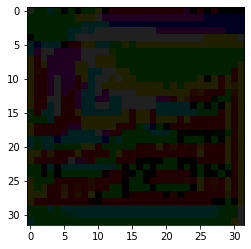

Noise max val: tensor(0.1255, device='cuda:2', grad_fn=<MaxBackward1>)


In [13]:
#Trigger generating stage
for param in poi_warm_up_model.parameters():
    param.requires_grad = False

batch_pert = torch.autograd.Variable(noise.cuda(), requires_grad=True)
batch_opt = torch.optim.RAdam(params=[batch_pert],lr=generating_lr_tri)
for minmin in tqdm.notebook.tqdm(range(gen_round)):
    loss_list = []
    for images, labels in trigger_gen_loaders:
        images, labels = images.cuda(), labels.cuda()
        new_images = torch.clone(images)
        clamp_batch_pert = torch.clamp(batch_pert,-l_inf_r*2,l_inf_r*2)
        new_images = torch.clamp(apply_noise_patch(clamp_batch_pert,new_images.clone(),mode=patch_mode),-1,1)
        per_logits = poi_warm_up_model.forward(new_images)
        loss = criterion(per_logits, labels)
        loss_regu = torch.mean(loss)
        batch_opt.zero_grad()
        loss_list.append(float(loss_regu.data))
        loss_regu.backward(retain_graph = True)
        batch_opt.step()
    ave_loss = np.average(np.array(loss_list))
    ave_grad = np.sum(abs(batch_pert.grad).detach().cpu().numpy())
    print('Gradient:',ave_grad,'Loss:', ave_loss)
    if ave_grad == 0:
        break

noise = torch.clamp(batch_pert,-l_inf_r*2,l_inf_r*2)
best_noise = noise.clone().detach().cpu()
plt.imshow(np.transpose(noise[0].detach().cpu(),(1,2,0)))
plt.show()
print('Noise max val:',noise.max())

In [14]:
#Save the trigger
import time
save_name = './checkpoint/best_noise'+'_'+ time.strftime("%m-%d-%H_%M_%S",time.localtime(time.time())) 
np.save(save_name, best_noise)

# Testing  attack effect

In [15]:
#Using this block if you only want to test the attack result.
# import imageio
# import cv2 as cv
# best_noise = torch.zeros((1, 3, noise_size, noise_size), device=device)
# noise_npy = np.load('./checkpoint/resnet18_trigger.npy')
# best_noise = torch.from_numpy(noise_npy).cuda()

In [16]:
#Poisoning amount use for the target class
poison_amount = 25

#Model uses for testing
noise_testing_model = ResNet18().cuda()    

#Training parameters
training_epochs = 200
training_lr = 0.1
test_batch_size = 150

#The multiple of noise amplification during testing
multi_test = 3

#random seed for testing stage
random_seed = 65

In [17]:
import torchvision.models as models
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)
model = noise_testing_model

optimizer = torch.optim.SGD(params=model.parameters(), lr=training_lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=training_epochs)

In [18]:
transform_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
poi_ori_train = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform_tensor)
poi_ori_test = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=False, transform=transform_tensor)
transform_after_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomHorizontalFlip(),
])

In [19]:
#Poison traing
random_poison_idx = random.sample(train_target_list, poison_amount)
poison_train_target = poison_image(poi_ori_train,random_poison_idx,best_noise.cpu(),transform_after_train)
print('Traing dataset size is:',len(poison_train_target)," Poison numbers is:",len(random_poison_idx))
clean_train_loader = DataLoader(poison_train_target, batch_size=test_batch_size, shuffle=True, num_workers=2)

Traing dataset size is: 50000  Poison numbers is: 25


In [20]:
#Attack success rate testing
test_non_target = list(np.where(np.array(test_label)!=lab)[0])
test_non_target_change_image_label = poison_image_label(poi_ori_test,test_non_target,best_noise.cpu()*multi_test,lab,None)
asr_loaders = torch.utils.data.DataLoader(test_non_target_change_image_label, batch_size=test_batch_size, shuffle=True, num_workers=2)
print('Poison test dataset size is:',len(test_non_target_change_image_label))

Poison test dataset size is: 9000


In [21]:
#Clean acc test dataset
clean_test_loader = torch.utils.data.DataLoader(ori_test, batch_size=test_batch_size, shuffle=False, num_workers=2)

In [22]:
#Target clean test dataset
test_target = list(np.where(np.array(test_label)==lab)[0])
target_test_set = Subset(ori_test,test_target)
target_test_loader = torch.utils.data.DataLoader(target_test_set, batch_size=test_batch_size, shuffle=True, num_workers=2)

In [23]:
from util import AverageMeter
train_ACC = []
test_ACC = []
clean_ACC = []
target_ACC = []

In [24]:
for epoch in tqdm.notebook.tqdm(range(training_epochs)):
    # Train
    model.train()
    acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    pbar = tqdm.notebook.tqdm(clean_train_loader, total=len(clean_train_loader))
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        model.zero_grad()
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(logits.data, 1)
        acc = (predicted == labels).sum().item()/labels.size(0)
        acc_meter.update(acc)
        loss_meter.update(loss.item())
        pbar.set_description("Acc %.2f Loss: %.2f" % (acc_meter.avg*100, loss_meter.avg))
    train_ACC.append(acc_meter.avg)
    print('Train_loss:',loss)
    scheduler.step()
    
    # Testing attack effect
    model.eval()
    correct, total = 0, 0
    for i, (images, labels) in enumerate(asr_loaders):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    acc = correct / total
    test_ACC.append(acc)
    print('\nAttack success rate %.2f' % (acc*100))
    print('Test_loss:',out_loss)
    
    correct_clean, total_clean = 0, 0
    for i, (images, labels) in enumerate(clean_test_loader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total_clean += labels.size(0)
            correct_clean += (predicted == labels).sum().item()
    acc_clean = correct_clean / total_clean
    clean_ACC.append(acc_clean)
    print('\nTest clean Accuracy %.2f' % (acc_clean*100))
    print('Test_loss:',out_loss)
    
    correct_tar, total_tar = 0, 0
    for i, (images, labels) in enumerate(target_test_loader):
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            logits = model(images)
            out_loss = criterion(logits,labels)
            _, predicted = torch.max(logits.data, 1)
            total_tar += labels.size(0)
            correct_tar += (predicted == labels).sum().item()
    acc_tar = correct_tar / total_tar
    target_ACC.append(acc_tar)
    print('\nTarget test clean Accuracy %.2f' % (acc_tar*100))
    print('Test_loss:',out_loss)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.7364, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.11
Test_loss: tensor(3.3612, device='cuda:2')

Test clean Accuracy 44.55
Test_loss: tensor(1.4679, device='cuda:2')

Target test clean Accuracy 6.80
Test_loss: tensor(2.0644, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.1617, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.11
Test_loss: tensor(5.7308, device='cuda:2')

Test clean Accuracy 55.09
Test_loss: tensor(1.4080, device='cuda:2')

Target test clean Accuracy 17.30
Test_loss: tensor(2.7777, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(1.0322, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.00
Test_loss: tensor(7.3072, device='cuda:2')

Test clean Accuracy 63.23
Test_loss: tensor(1.2769, device='cuda:2')

Target test clean Accuracy 42.70
Test_loss: tensor(1.4344, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.9586, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 1.68
Test_loss: tensor(4.2194, device='cuda:2')

Test clean Accuracy 65.93
Test_loss: tensor(0.9144, device='cuda:2')

Target test clean Accuracy 62.70
Test_loss: tensor(0.9063, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6797, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.16
Test_loss: tensor(5.9248, device='cuda:2')

Test clean Accuracy 62.27
Test_loss: tensor(1.0445, device='cuda:2')

Target test clean Accuracy 73.30
Test_loss: tensor(0.6505, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3980, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.01
Test_loss: tensor(7.8975, device='cuda:2')

Test clean Accuracy 73.86
Test_loss: tensor(0.8141, device='cuda:2')

Target test clean Accuracy 59.10
Test_loss: tensor(1.4899, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5339, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.07
Test_loss: tensor(4.7972, device='cuda:2')

Test clean Accuracy 71.54
Test_loss: tensor(0.8579, device='cuda:2')

Target test clean Accuracy 58.50
Test_loss: tensor(1.0858, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5986, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.00
Test_loss: tensor(7.2700, device='cuda:2')

Test clean Accuracy 78.05
Test_loss: tensor(0.6389, device='cuda:2')

Target test clean Accuracy 60.50
Test_loss: tensor(1.3858, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4944, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 5.31
Test_loss: tensor(3.3477, device='cuda:2')

Test clean Accuracy 78.16
Test_loss: tensor(0.6524, device='cuda:2')

Target test clean Accuracy 81.40
Test_loss: tensor(0.5526, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6483, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.62
Test_loss: tensor(6.1355, device='cuda:2')

Test clean Accuracy 79.05
Test_loss: tensor(0.6775, device='cuda:2')

Target test clean Accuracy 84.20
Test_loss: tensor(0.6025, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6828, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 15.96
Test_loss: tensor(2.4104, device='cuda:2')

Test clean Accuracy 77.56
Test_loss: tensor(0.7147, device='cuda:2')

Target test clean Accuracy 67.60
Test_loss: tensor(0.7974, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5316, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.11
Test_loss: tensor(7.9061, device='cuda:2')

Test clean Accuracy 79.40
Test_loss: tensor(0.7816, device='cuda:2')

Target test clean Accuracy 70.30
Test_loss: tensor(0.9162, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4670, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.00
Test_loss: tensor(6.5759, device='cuda:2')

Test clean Accuracy 80.52
Test_loss: tensor(0.6618, device='cuda:2')

Target test clean Accuracy 53.40
Test_loss: tensor(1.6315, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6761, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.97
Test_loss: tensor(4.5380, device='cuda:2')

Test clean Accuracy 82.46
Test_loss: tensor(0.4282, device='cuda:2')

Target test clean Accuracy 63.70
Test_loss: tensor(1.2425, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.7652, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.00
Test_loss: tensor(10.0775, device='cuda:2')

Test clean Accuracy 83.81
Test_loss: tensor(0.3348, device='cuda:2')

Target test clean Accuracy 78.50
Test_loss: tensor(0.5866, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4618, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 26.47
Test_loss: tensor(1.9873, device='cuda:2')

Test clean Accuracy 84.67
Test_loss: tensor(0.4578, device='cuda:2')

Target test clean Accuracy 83.30
Test_loss: tensor(0.4939, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3844, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.07
Test_loss: tensor(4.9996, device='cuda:2')

Test clean Accuracy 83.46
Test_loss: tensor(0.4303, device='cuda:2')

Target test clean Accuracy 66.90
Test_loss: tensor(0.9403, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4600, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.26
Test_loss: tensor(6.4714, device='cuda:2')

Test clean Accuracy 82.43
Test_loss: tensor(0.4901, device='cuda:2')

Target test clean Accuracy 70.60
Test_loss: tensor(1.0569, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5222, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 15.02
Test_loss: tensor(2.6657, device='cuda:2')

Test clean Accuracy 84.13
Test_loss: tensor(0.4373, device='cuda:2')

Target test clean Accuracy 73.70
Test_loss: tensor(0.6620, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6596, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 24.72
Test_loss: tensor(2.1667, device='cuda:2')

Test clean Accuracy 82.01
Test_loss: tensor(0.5597, device='cuda:2')

Target test clean Accuracy 78.70
Test_loss: tensor(0.5776, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.6125, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 1.54
Test_loss: tensor(4.2872, device='cuda:2')

Test clean Accuracy 84.45
Test_loss: tensor(0.4050, device='cuda:2')

Target test clean Accuracy 64.60
Test_loss: tensor(0.9511, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2904, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 7.01
Test_loss: tensor(2.9048, device='cuda:2')

Test clean Accuracy 84.54
Test_loss: tensor(0.5643, device='cuda:2')

Target test clean Accuracy 75.50
Test_loss: tensor(0.7974, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3712, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.09
Test_loss: tensor(5.1379, device='cuda:2')

Test clean Accuracy 83.37
Test_loss: tensor(0.4419, device='cuda:2')

Target test clean Accuracy 66.20
Test_loss: tensor(0.8499, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3379, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 5.69
Test_loss: tensor(2.1919, device='cuda:2')

Test clean Accuracy 82.76
Test_loss: tensor(0.3571, device='cuda:2')

Target test clean Accuracy 85.70
Test_loss: tensor(0.3284, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1908, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 19.92
Test_loss: tensor(3.1981, device='cuda:2')

Test clean Accuracy 81.48
Test_loss: tensor(0.5390, device='cuda:2')

Target test clean Accuracy 79.20
Test_loss: tensor(0.5430, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4357, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.50
Test_loss: tensor(4.9280, device='cuda:2')

Test clean Accuracy 84.11
Test_loss: tensor(0.4235, device='cuda:2')

Target test clean Accuracy 79.40
Test_loss: tensor(0.4669, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3214, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 50.79
Test_loss: tensor(1.4695, device='cuda:2')

Test clean Accuracy 85.71
Test_loss: tensor(0.3441, device='cuda:2')

Target test clean Accuracy 82.80
Test_loss: tensor(0.8197, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5000, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 1.27
Test_loss: tensor(5.1673, device='cuda:2')

Test clean Accuracy 84.76
Test_loss: tensor(0.3802, device='cuda:2')

Target test clean Accuracy 80.90
Test_loss: tensor(0.6340, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4056, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.10
Test_loss: tensor(5.0589, device='cuda:2')

Test clean Accuracy 81.84
Test_loss: tensor(0.4535, device='cuda:2')

Target test clean Accuracy 81.80
Test_loss: tensor(0.3718, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2863, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.46
Test_loss: tensor(7.0489, device='cuda:2')

Test clean Accuracy 85.68
Test_loss: tensor(0.3082, device='cuda:2')

Target test clean Accuracy 79.60
Test_loss: tensor(0.7239, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5519, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 8.91
Test_loss: tensor(4.5762, device='cuda:2')

Test clean Accuracy 81.85
Test_loss: tensor(0.5539, device='cuda:2')

Target test clean Accuracy 64.90
Test_loss: tensor(1.0239, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3382, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 69.67
Test_loss: tensor(0.9614, device='cuda:2')

Test clean Accuracy 82.26
Test_loss: tensor(0.3355, device='cuda:2')

Target test clean Accuracy 90.70
Test_loss: tensor(0.2807, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3410, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 4.17
Test_loss: tensor(3.6732, device='cuda:2')

Test clean Accuracy 82.08
Test_loss: tensor(0.5835, device='cuda:2')

Target test clean Accuracy 89.70
Test_loss: tensor(0.3811, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3656, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 26.60
Test_loss: tensor(2.2442, device='cuda:2')

Test clean Accuracy 83.76
Test_loss: tensor(0.5188, device='cuda:2')

Target test clean Accuracy 75.20
Test_loss: tensor(0.7670, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2554, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 73.60
Test_loss: tensor(0.8654, device='cuda:2')

Test clean Accuracy 86.90
Test_loss: tensor(0.4210, device='cuda:2')

Target test clean Accuracy 82.20
Test_loss: tensor(0.2609, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1734, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 62.67
Test_loss: tensor(1.1449, device='cuda:2')

Test clean Accuracy 86.27
Test_loss: tensor(0.4251, device='cuda:2')

Target test clean Accuracy 80.40
Test_loss: tensor(0.7210, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4504, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 30.83
Test_loss: tensor(2.2735, device='cuda:2')

Test clean Accuracy 83.22
Test_loss: tensor(0.4530, device='cuda:2')

Target test clean Accuracy 91.30
Test_loss: tensor(0.3499, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4347, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 83.38
Test_loss: tensor(0.6255, device='cuda:2')

Test clean Accuracy 85.62
Test_loss: tensor(0.3865, device='cuda:2')

Target test clean Accuracy 88.30
Test_loss: tensor(0.4115, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1380, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 16.31
Test_loss: tensor(2.4588, device='cuda:2')

Test clean Accuracy 85.48
Test_loss: tensor(0.3583, device='cuda:2')

Target test clean Accuracy 86.30
Test_loss: tensor(0.4102, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4675, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 83.96
Test_loss: tensor(0.5147, device='cuda:2')

Test clean Accuracy 84.16
Test_loss: tensor(0.4147, device='cuda:2')

Target test clean Accuracy 86.80
Test_loss: tensor(0.2912, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4586, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 3.72
Test_loss: tensor(4.2453, device='cuda:2')

Test clean Accuracy 83.25
Test_loss: tensor(0.5324, device='cuda:2')

Target test clean Accuracy 89.00
Test_loss: tensor(0.2066, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5293, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 74.56
Test_loss: tensor(0.6159, device='cuda:2')

Test clean Accuracy 84.52
Test_loss: tensor(0.3020, device='cuda:2')

Target test clean Accuracy 88.90
Test_loss: tensor(0.1885, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1863, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 27.10
Test_loss: tensor(1.9540, device='cuda:2')

Test clean Accuracy 82.82
Test_loss: tensor(0.4731, device='cuda:2')

Target test clean Accuracy 90.70
Test_loss: tensor(0.2668, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5255, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 5.61
Test_loss: tensor(3.2685, device='cuda:2')

Test clean Accuracy 84.33
Test_loss: tensor(0.4498, device='cuda:2')

Target test clean Accuracy 82.20
Test_loss: tensor(0.3833, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4727, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 3.96
Test_loss: tensor(5.3697, device='cuda:2')

Test clean Accuracy 83.89
Test_loss: tensor(0.4256, device='cuda:2')

Target test clean Accuracy 92.80
Test_loss: tensor(0.3248, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2704, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 7.74
Test_loss: tensor(3.9309, device='cuda:2')

Test clean Accuracy 85.90
Test_loss: tensor(0.4239, device='cuda:2')

Target test clean Accuracy 84.70
Test_loss: tensor(0.4613, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3143, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.73
Test_loss: tensor(3.9163, device='cuda:2')

Test clean Accuracy 85.75
Test_loss: tensor(0.4426, device='cuda:2')

Target test clean Accuracy 73.00
Test_loss: tensor(0.7947, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4613, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 6.60
Test_loss: tensor(3.7871, device='cuda:2')

Test clean Accuracy 85.62
Test_loss: tensor(0.3602, device='cuda:2')

Target test clean Accuracy 78.80
Test_loss: tensor(0.6738, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1754, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 8.83
Test_loss: tensor(3.5429, device='cuda:2')

Test clean Accuracy 87.03
Test_loss: tensor(0.2458, device='cuda:2')

Target test clean Accuracy 74.40
Test_loss: tensor(0.7991, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2610, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 78.20
Test_loss: tensor(0.6589, device='cuda:2')

Test clean Accuracy 84.33
Test_loss: tensor(0.4084, device='cuda:2')

Target test clean Accuracy 85.90
Test_loss: tensor(0.3479, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5999, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 1.86
Test_loss: tensor(5.1058, device='cuda:2')

Test clean Accuracy 86.33
Test_loss: tensor(0.3753, device='cuda:2')

Target test clean Accuracy 85.70
Test_loss: tensor(0.3567, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3297, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 28.86
Test_loss: tensor(1.5992, device='cuda:2')

Test clean Accuracy 87.24
Test_loss: tensor(0.3218, device='cuda:2')

Target test clean Accuracy 84.60
Test_loss: tensor(0.4471, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2368, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 1.03
Test_loss: tensor(4.4947, device='cuda:2')

Test clean Accuracy 85.99
Test_loss: tensor(0.4120, device='cuda:2')

Target test clean Accuracy 83.90
Test_loss: tensor(0.5930, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3606, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 2.93
Test_loss: tensor(4.4491, device='cuda:2')

Test clean Accuracy 82.78
Test_loss: tensor(0.3356, device='cuda:2')

Target test clean Accuracy 84.00
Test_loss: tensor(0.4827, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4330, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 6.53
Test_loss: tensor(4.0208, device='cuda:2')

Test clean Accuracy 81.45
Test_loss: tensor(0.4476, device='cuda:2')

Target test clean Accuracy 77.50
Test_loss: tensor(0.6890, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3179, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 8.84
Test_loss: tensor(2.7184, device='cuda:2')

Test clean Accuracy 83.20
Test_loss: tensor(0.4602, device='cuda:2')

Target test clean Accuracy 64.70
Test_loss: tensor(1.2433, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4370, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 95.84
Test_loss: tensor(0.1901, device='cuda:2')

Test clean Accuracy 85.56
Test_loss: tensor(0.3493, device='cuda:2')

Target test clean Accuracy 82.70
Test_loss: tensor(0.4858, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.7866, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 92.22
Test_loss: tensor(0.4666, device='cuda:2')

Test clean Accuracy 86.20
Test_loss: tensor(0.2582, device='cuda:2')

Target test clean Accuracy 92.30
Test_loss: tensor(0.1926, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4546, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 73.82
Test_loss: tensor(0.7143, device='cuda:2')

Test clean Accuracy 86.94
Test_loss: tensor(0.3620, device='cuda:2')

Target test clean Accuracy 87.00
Test_loss: tensor(0.4541, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1973, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 95.36
Test_loss: tensor(0.2905, device='cuda:2')

Test clean Accuracy 85.80
Test_loss: tensor(0.3339, device='cuda:2')

Target test clean Accuracy 86.60
Test_loss: tensor(0.4152, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1344, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 19.44
Test_loss: tensor(2.2937, device='cuda:2')

Test clean Accuracy 86.71
Test_loss: tensor(0.2422, device='cuda:2')

Target test clean Accuracy 68.20
Test_loss: tensor(0.9734, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2090, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 92.70
Test_loss: tensor(0.2858, device='cuda:2')

Test clean Accuracy 86.41
Test_loss: tensor(0.2459, device='cuda:2')

Target test clean Accuracy 92.00
Test_loss: tensor(0.1752, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2782, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 3.24
Test_loss: tensor(3.4587, device='cuda:2')

Test clean Accuracy 84.90
Test_loss: tensor(0.3357, device='cuda:2')

Target test clean Accuracy 92.60
Test_loss: tensor(0.1617, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2489, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 18.19
Test_loss: tensor(2.5553, device='cuda:2')

Test clean Accuracy 86.14
Test_loss: tensor(0.5169, device='cuda:2')

Target test clean Accuracy 83.30
Test_loss: tensor(0.3894, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2523, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 33.56
Test_loss: tensor(2.3644, device='cuda:2')

Test clean Accuracy 89.09
Test_loss: tensor(0.2578, device='cuda:2')

Target test clean Accuracy 88.50
Test_loss: tensor(0.4694, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.5653, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 2.13
Test_loss: tensor(3.0529, device='cuda:2')

Test clean Accuracy 87.37
Test_loss: tensor(0.3384, device='cuda:2')

Target test clean Accuracy 80.00
Test_loss: tensor(0.7060, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1865, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 99.57
Test_loss: tensor(0.0276, device='cuda:2')

Test clean Accuracy 87.20
Test_loss: tensor(0.3476, device='cuda:2')

Target test clean Accuracy 86.20
Test_loss: tensor(0.2756, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3612, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 3.26
Test_loss: tensor(3.5895, device='cuda:2')

Test clean Accuracy 87.91
Test_loss: tensor(0.3462, device='cuda:2')

Target test clean Accuracy 85.20
Test_loss: tensor(0.4000, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2152, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 6.23
Test_loss: tensor(3.3412, device='cuda:2')

Test clean Accuracy 86.74
Test_loss: tensor(0.3287, device='cuda:2')

Target test clean Accuracy 78.50
Test_loss: tensor(0.5447, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3507, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 62.72
Test_loss: tensor(1.0977, device='cuda:2')

Test clean Accuracy 88.83
Test_loss: tensor(0.3271, device='cuda:2')

Target test clean Accuracy 83.20
Test_loss: tensor(0.5834, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4216, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 72.66
Test_loss: tensor(0.9404, device='cuda:2')

Test clean Accuracy 84.67
Test_loss: tensor(0.4543, device='cuda:2')

Target test clean Accuracy 84.80
Test_loss: tensor(0.3788, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2381, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 15.00
Test_loss: tensor(3.0951, device='cuda:2')

Test clean Accuracy 83.38
Test_loss: tensor(0.5786, device='cuda:2')

Target test clean Accuracy 63.70
Test_loss: tensor(1.4699, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1897, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 11.27
Test_loss: tensor(2.8092, device='cuda:2')

Test clean Accuracy 88.17
Test_loss: tensor(0.3227, device='cuda:2')

Target test clean Accuracy 80.10
Test_loss: tensor(0.4936, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2950, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 1.49
Test_loss: tensor(2.8881, device='cuda:2')

Test clean Accuracy 87.69
Test_loss: tensor(0.2614, device='cuda:2')

Target test clean Accuracy 77.20
Test_loss: tensor(0.6362, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1888, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.44
Test_loss: tensor(4.4929, device='cuda:2')

Test clean Accuracy 87.16
Test_loss: tensor(0.2707, device='cuda:2')

Target test clean Accuracy 86.60
Test_loss: tensor(0.3843, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2898, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 3.41
Test_loss: tensor(4.3872, device='cuda:2')

Test clean Accuracy 85.86
Test_loss: tensor(0.2489, device='cuda:2')

Target test clean Accuracy 89.60
Test_loss: tensor(0.2304, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3399, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 2.52
Test_loss: tensor(3.6513, device='cuda:2')

Test clean Accuracy 79.77
Test_loss: tensor(0.7270, device='cuda:2')

Target test clean Accuracy 74.40
Test_loss: tensor(0.9087, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2929, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 7.57
Test_loss: tensor(2.1457, device='cuda:2')

Test clean Accuracy 88.79
Test_loss: tensor(0.2554, device='cuda:2')

Target test clean Accuracy 84.20
Test_loss: tensor(0.5630, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4189, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 18.69
Test_loss: tensor(2.4936, device='cuda:2')

Test clean Accuracy 85.16
Test_loss: tensor(0.2757, device='cuda:2')

Target test clean Accuracy 88.90
Test_loss: tensor(0.2760, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2597, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 46.80
Test_loss: tensor(2.5386, device='cuda:2')

Test clean Accuracy 87.07
Test_loss: tensor(0.2503, device='cuda:2')

Target test clean Accuracy 91.70
Test_loss: tensor(0.3130, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1706, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 61.37
Test_loss: tensor(1.3167, device='cuda:2')

Test clean Accuracy 84.94
Test_loss: tensor(0.3312, device='cuda:2')

Target test clean Accuracy 87.10
Test_loss: tensor(0.3955, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1431, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 99.43
Test_loss: tensor(0.0437, device='cuda:2')

Test clean Accuracy 84.79
Test_loss: tensor(0.3533, device='cuda:2')

Target test clean Accuracy 87.80
Test_loss: tensor(0.3712, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3385, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 43.76
Test_loss: tensor(1.7483, device='cuda:2')

Test clean Accuracy 89.58
Test_loss: tensor(0.2075, device='cuda:2')

Target test clean Accuracy 86.90
Test_loss: tensor(0.3347, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1831, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 69.04
Test_loss: tensor(1.0676, device='cuda:2')

Test clean Accuracy 86.84
Test_loss: tensor(0.3725, device='cuda:2')

Target test clean Accuracy 86.50
Test_loss: tensor(0.1873, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3872, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 58.34
Test_loss: tensor(1.4250, device='cuda:2')

Test clean Accuracy 88.16
Test_loss: tensor(0.2560, device='cuda:2')

Target test clean Accuracy 82.40
Test_loss: tensor(0.5362, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3820, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 76.61
Test_loss: tensor(0.6215, device='cuda:2')

Test clean Accuracy 85.79
Test_loss: tensor(0.4456, device='cuda:2')

Target test clean Accuracy 83.60
Test_loss: tensor(0.5788, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2240, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 13.53
Test_loss: tensor(2.7973, device='cuda:2')

Test clean Accuracy 88.60
Test_loss: tensor(0.2647, device='cuda:2')

Target test clean Accuracy 83.80
Test_loss: tensor(0.6265, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2402, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.00
Test_loss: tensor(9.8301, device='cuda:2')

Test clean Accuracy 89.33
Test_loss: tensor(0.3205, device='cuda:2')

Target test clean Accuracy 78.30
Test_loss: tensor(0.6390, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3524, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 79.68
Test_loss: tensor(0.6328, device='cuda:2')

Test clean Accuracy 88.52
Test_loss: tensor(0.1739, device='cuda:2')

Target test clean Accuracy 83.10
Test_loss: tensor(0.4809, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3211, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 16.29
Test_loss: tensor(4.1818, device='cuda:2')

Test clean Accuracy 87.91
Test_loss: tensor(0.2456, device='cuda:2')

Target test clean Accuracy 78.60
Test_loss: tensor(0.6467, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2187, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 96.46
Test_loss: tensor(0.2189, device='cuda:2')

Test clean Accuracy 88.21
Test_loss: tensor(0.3109, device='cuda:2')

Target test clean Accuracy 92.50
Test_loss: tensor(0.1888, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1478, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.84
Test_loss: tensor(5.3836, device='cuda:2')

Test clean Accuracy 86.98
Test_loss: tensor(0.3757, device='cuda:2')

Target test clean Accuracy 84.80
Test_loss: tensor(0.3754, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3306, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 86.14
Test_loss: tensor(0.4449, device='cuda:2')

Test clean Accuracy 88.62
Test_loss: tensor(0.2073, device='cuda:2')

Target test clean Accuracy 77.80
Test_loss: tensor(0.7746, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.3630, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 5.63
Test_loss: tensor(4.6715, device='cuda:2')

Test clean Accuracy 89.30
Test_loss: tensor(0.2132, device='cuda:2')

Target test clean Accuracy 88.20
Test_loss: tensor(0.3449, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.4696, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 59.20
Test_loss: tensor(1.3005, device='cuda:2')

Test clean Accuracy 88.60
Test_loss: tensor(0.2452, device='cuda:2')

Target test clean Accuracy 71.40
Test_loss: tensor(1.0640, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1711, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 18.78
Test_loss: tensor(3.6446, device='cuda:2')

Test clean Accuracy 86.83
Test_loss: tensor(0.3534, device='cuda:2')

Target test clean Accuracy 79.40
Test_loss: tensor(0.4759, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2471, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 92.06
Test_loss: tensor(0.3722, device='cuda:2')

Test clean Accuracy 88.45
Test_loss: tensor(0.2236, device='cuda:2')

Target test clean Accuracy 84.50
Test_loss: tensor(0.3552, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2626, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 45.91
Test_loss: tensor(1.3291, device='cuda:2')

Test clean Accuracy 89.77
Test_loss: tensor(0.3101, device='cuda:2')

Target test clean Accuracy 88.60
Test_loss: tensor(0.3848, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1565, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 82.80
Test_loss: tensor(0.5214, device='cuda:2')

Test clean Accuracy 88.16
Test_loss: tensor(0.2768, device='cuda:2')

Target test clean Accuracy 84.50
Test_loss: tensor(0.4889, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2094, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 85.54
Test_loss: tensor(0.5787, device='cuda:2')

Test clean Accuracy 88.83
Test_loss: tensor(0.3939, device='cuda:2')

Target test clean Accuracy 88.20
Test_loss: tensor(0.5051, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1699, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 45.57
Test_loss: tensor(1.5073, device='cuda:2')

Test clean Accuracy 87.86
Test_loss: tensor(0.3112, device='cuda:2')

Target test clean Accuracy 92.40
Test_loss: tensor(0.1882, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1809, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 27.63
Test_loss: tensor(2.2867, device='cuda:2')

Test clean Accuracy 89.99
Test_loss: tensor(0.2489, device='cuda:2')

Target test clean Accuracy 89.50
Test_loss: tensor(0.5240, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1158, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 99.16
Test_loss: tensor(0.0456, device='cuda:2')

Test clean Accuracy 89.57
Test_loss: tensor(0.1790, device='cuda:2')

Target test clean Accuracy 84.50
Test_loss: tensor(0.4311, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2205, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 41.33
Test_loss: tensor(2.3296, device='cuda:2')

Test clean Accuracy 87.80
Test_loss: tensor(0.3028, device='cuda:2')

Target test clean Accuracy 78.10
Test_loss: tensor(0.7457, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1292, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 89.24
Test_loss: tensor(0.3682, device='cuda:2')

Test clean Accuracy 89.40
Test_loss: tensor(0.3812, device='cuda:2')

Target test clean Accuracy 92.50
Test_loss: tensor(0.3195, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0722, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 92.42
Test_loss: tensor(0.2568, device='cuda:2')

Test clean Accuracy 90.37
Test_loss: tensor(0.1633, device='cuda:2')

Target test clean Accuracy 84.90
Test_loss: tensor(0.4166, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2022, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 59.81
Test_loss: tensor(1.5164, device='cuda:2')

Test clean Accuracy 86.56
Test_loss: tensor(0.4503, device='cuda:2')

Target test clean Accuracy 95.70
Test_loss: tensor(0.1005, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2138, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 93.52
Test_loss: tensor(0.1588, device='cuda:2')

Test clean Accuracy 88.89
Test_loss: tensor(0.2781, device='cuda:2')

Target test clean Accuracy 88.40
Test_loss: tensor(0.4479, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1253, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 92.64
Test_loss: tensor(0.3170, device='cuda:2')

Test clean Accuracy 88.91
Test_loss: tensor(0.2768, device='cuda:2')

Target test clean Accuracy 82.70
Test_loss: tensor(0.4614, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0603, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 36.84
Test_loss: tensor(2.1618, device='cuda:2')

Test clean Accuracy 88.90
Test_loss: tensor(0.3120, device='cuda:2')

Target test clean Accuracy 86.10
Test_loss: tensor(0.5282, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2609, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 96.30
Test_loss: tensor(0.2517, device='cuda:2')

Test clean Accuracy 90.39
Test_loss: tensor(0.2818, device='cuda:2')

Target test clean Accuracy 84.20
Test_loss: tensor(0.7042, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2161, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 11.74
Test_loss: tensor(3.1499, device='cuda:2')

Test clean Accuracy 89.97
Test_loss: tensor(0.1806, device='cuda:2')

Target test clean Accuracy 89.20
Test_loss: tensor(0.4239, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1725, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 56.28
Test_loss: tensor(1.4104, device='cuda:2')

Test clean Accuracy 89.95
Test_loss: tensor(0.2951, device='cuda:2')

Target test clean Accuracy 84.70
Test_loss: tensor(0.3816, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1846, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 59.62
Test_loss: tensor(1.2853, device='cuda:2')

Test clean Accuracy 89.41
Test_loss: tensor(0.2602, device='cuda:2')

Target test clean Accuracy 90.30
Test_loss: tensor(0.2284, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1845, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 98.23
Test_loss: tensor(0.0480, device='cuda:2')

Test clean Accuracy 90.90
Test_loss: tensor(0.1745, device='cuda:2')

Target test clean Accuracy 88.90
Test_loss: tensor(0.3919, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0955, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 96.27
Test_loss: tensor(0.2038, device='cuda:2')

Test clean Accuracy 90.29
Test_loss: tensor(0.3108, device='cuda:2')

Target test clean Accuracy 84.10
Test_loss: tensor(0.5759, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1492, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 41.21
Test_loss: tensor(2.2129, device='cuda:2')

Test clean Accuracy 91.43
Test_loss: tensor(0.2014, device='cuda:2')

Target test clean Accuracy 85.10
Test_loss: tensor(0.5250, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1196, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 95.18
Test_loss: tensor(0.1017, device='cuda:2')

Test clean Accuracy 91.23
Test_loss: tensor(0.1991, device='cuda:2')

Target test clean Accuracy 89.50
Test_loss: tensor(0.3218, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2055, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 69.59
Test_loss: tensor(1.0112, device='cuda:2')

Test clean Accuracy 91.05
Test_loss: tensor(0.1609, device='cuda:2')

Target test clean Accuracy 91.60
Test_loss: tensor(0.1792, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1643, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 82.81
Test_loss: tensor(0.4696, device='cuda:2')

Test clean Accuracy 89.94
Test_loss: tensor(0.3094, device='cuda:2')

Target test clean Accuracy 84.80
Test_loss: tensor(0.5713, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0536, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.62
Test_loss: tensor(5.7483, device='cuda:2')

Test clean Accuracy 91.42
Test_loss: tensor(0.2622, device='cuda:2')

Target test clean Accuracy 88.40
Test_loss: tensor(0.5425, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1242, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 98.34
Test_loss: tensor(0.0571, device='cuda:2')

Test clean Accuracy 89.73
Test_loss: tensor(0.2190, device='cuda:2')

Target test clean Accuracy 84.60
Test_loss: tensor(0.6223, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0520, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 6.20
Test_loss: tensor(3.5279, device='cuda:2')

Test clean Accuracy 89.32
Test_loss: tensor(0.2514, device='cuda:2')

Target test clean Accuracy 83.30
Test_loss: tensor(0.6734, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0951, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 59.99
Test_loss: tensor(1.3110, device='cuda:2')

Test clean Accuracy 89.80
Test_loss: tensor(0.3086, device='cuda:2')

Target test clean Accuracy 93.20
Test_loss: tensor(0.1606, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1096, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 90.58
Test_loss: tensor(0.2516, device='cuda:2')

Test clean Accuracy 91.02
Test_loss: tensor(0.1375, device='cuda:2')

Target test clean Accuracy 92.00
Test_loss: tensor(0.3144, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1175, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 87.04
Test_loss: tensor(0.3684, device='cuda:2')

Test clean Accuracy 90.70
Test_loss: tensor(0.2471, device='cuda:2')

Target test clean Accuracy 87.10
Test_loss: tensor(0.6837, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0554, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 53.60
Test_loss: tensor(1.5904, device='cuda:2')

Test clean Accuracy 91.25
Test_loss: tensor(0.2004, device='cuda:2')

Target test clean Accuracy 89.10
Test_loss: tensor(0.3292, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1762, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 74.41
Test_loss: tensor(0.8512, device='cuda:2')

Test clean Accuracy 90.67
Test_loss: tensor(0.1744, device='cuda:2')

Target test clean Accuracy 87.20
Test_loss: tensor(0.2198, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1899, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 67.50
Test_loss: tensor(1.1285, device='cuda:2')

Test clean Accuracy 90.50
Test_loss: tensor(0.1117, device='cuda:2')

Target test clean Accuracy 90.80
Test_loss: tensor(0.2103, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1544, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 18.88
Test_loss: tensor(3.4163, device='cuda:2')

Test clean Accuracy 90.60
Test_loss: tensor(0.2420, device='cuda:2')

Target test clean Accuracy 87.30
Test_loss: tensor(0.5590, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.2087, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 61.92
Test_loss: tensor(1.3259, device='cuda:2')

Test clean Accuracy 90.50
Test_loss: tensor(0.2571, device='cuda:2')

Target test clean Accuracy 83.50
Test_loss: tensor(0.5849, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0276, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 56.73
Test_loss: tensor(1.7648, device='cuda:2')

Test clean Accuracy 90.81
Test_loss: tensor(0.2758, device='cuda:2')

Target test clean Accuracy 94.10
Test_loss: tensor(0.1722, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1295, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 77.69
Test_loss: tensor(0.8765, device='cuda:2')

Test clean Accuracy 89.96
Test_loss: tensor(0.1948, device='cuda:2')

Target test clean Accuracy 94.90
Test_loss: tensor(0.2053, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1179, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 1.08
Test_loss: tensor(5.8622, device='cuda:2')

Test clean Accuracy 91.45
Test_loss: tensor(0.2398, device='cuda:2')

Target test clean Accuracy 83.40
Test_loss: tensor(0.4239, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0166, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 0.28
Test_loss: tensor(5.6569, device='cuda:2')

Test clean Accuracy 92.32
Test_loss: tensor(0.1224, device='cuda:2')

Target test clean Accuracy 86.80
Test_loss: tensor(0.3073, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0682, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 49.04
Test_loss: tensor(1.8081, device='cuda:2')

Test clean Accuracy 91.52
Test_loss: tensor(0.1339, device='cuda:2')

Target test clean Accuracy 93.90
Test_loss: tensor(0.1637, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1175, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 95.40
Test_loss: tensor(0.2920, device='cuda:2')

Test clean Accuracy 91.44
Test_loss: tensor(0.2487, device='cuda:2')

Target test clean Accuracy 89.70
Test_loss: tensor(0.3371, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0721, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 71.59
Test_loss: tensor(0.8701, device='cuda:2')

Test clean Accuracy 91.06
Test_loss: tensor(0.2078, device='cuda:2')

Target test clean Accuracy 93.80
Test_loss: tensor(0.3520, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1360, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 99.04
Test_loss: tensor(0.0419, device='cuda:2')

Test clean Accuracy 92.30
Test_loss: tensor(0.1457, device='cuda:2')

Target test clean Accuracy 91.60
Test_loss: tensor(0.4307, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0362, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 76.32
Test_loss: tensor(0.7416, device='cuda:2')

Test clean Accuracy 92.48
Test_loss: tensor(0.1431, device='cuda:2')

Target test clean Accuracy 86.30
Test_loss: tensor(0.4911, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0487, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 17.32
Test_loss: tensor(3.3660, device='cuda:2')

Test clean Accuracy 92.40
Test_loss: tensor(0.2089, device='cuda:2')

Target test clean Accuracy 94.50
Test_loss: tensor(0.2742, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0916, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 94.79
Test_loss: tensor(0.1812, device='cuda:2')

Test clean Accuracy 92.33
Test_loss: tensor(0.1976, device='cuda:2')

Target test clean Accuracy 86.90
Test_loss: tensor(0.6730, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0255, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 86.01
Test_loss: tensor(0.3129, device='cuda:2')

Test clean Accuracy 92.67
Test_loss: tensor(0.1625, device='cuda:2')

Target test clean Accuracy 92.30
Test_loss: tensor(0.5317, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0090, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 45.00
Test_loss: tensor(2.3862, device='cuda:2')

Test clean Accuracy 92.50
Test_loss: tensor(0.1204, device='cuda:2')

Target test clean Accuracy 92.10
Test_loss: tensor(0.1221, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0612, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 95.79
Test_loss: tensor(0.0856, device='cuda:2')

Test clean Accuracy 91.52
Test_loss: tensor(0.2539, device='cuda:2')

Target test clean Accuracy 93.90
Test_loss: tensor(0.3229, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0067, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 89.32
Test_loss: tensor(0.3044, device='cuda:2')

Test clean Accuracy 92.20
Test_loss: tensor(0.1298, device='cuda:2')

Target test clean Accuracy 87.80
Test_loss: tensor(0.6127, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0323, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 88.92
Test_loss: tensor(0.4440, device='cuda:2')

Test clean Accuracy 92.01
Test_loss: tensor(0.1805, device='cuda:2')

Target test clean Accuracy 87.60
Test_loss: tensor(0.6852, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0899, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 69.79
Test_loss: tensor(1.4046, device='cuda:2')

Test clean Accuracy 92.07
Test_loss: tensor(0.1967, device='cuda:2')

Target test clean Accuracy 87.60
Test_loss: tensor(0.6486, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0029, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 93.38
Test_loss: tensor(0.2826, device='cuda:2')

Test clean Accuracy 93.03
Test_loss: tensor(0.2378, device='cuda:2')

Target test clean Accuracy 89.20
Test_loss: tensor(0.1967, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.1676, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 93.10
Test_loss: tensor(0.2761, device='cuda:2')

Test clean Accuracy 92.72
Test_loss: tensor(0.1425, device='cuda:2')

Target test clean Accuracy 92.10
Test_loss: tensor(0.3425, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0953, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 99.42
Test_loss: tensor(0.0438, device='cuda:2')

Test clean Accuracy 92.55
Test_loss: tensor(0.2261, device='cuda:2')

Target test clean Accuracy 91.70
Test_loss: tensor(0.4453, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0155, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 46.48
Test_loss: tensor(1.8632, device='cuda:2')

Test clean Accuracy 93.03
Test_loss: tensor(0.1825, device='cuda:2')

Target test clean Accuracy 89.30
Test_loss: tensor(0.4679, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0279, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 54.99
Test_loss: tensor(1.2413, device='cuda:2')

Test clean Accuracy 92.89
Test_loss: tensor(0.1333, device='cuda:2')

Target test clean Accuracy 90.10
Test_loss: tensor(0.4027, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0114, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 30.46
Test_loss: tensor(2.0644, device='cuda:2')

Test clean Accuracy 93.13
Test_loss: tensor(0.1610, device='cuda:2')

Target test clean Accuracy 92.20
Test_loss: tensor(0.1828, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0044, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 89.77
Test_loss: tensor(0.3730, device='cuda:2')

Test clean Accuracy 93.50
Test_loss: tensor(0.1851, device='cuda:2')

Target test clean Accuracy 88.30
Test_loss: tensor(0.5099, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0076, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 12.97
Test_loss: tensor(3.9348, device='cuda:2')

Test clean Accuracy 93.46
Test_loss: tensor(0.1124, device='cuda:2')

Target test clean Accuracy 88.50
Test_loss: tensor(0.4166, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0442, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 96.31
Test_loss: tensor(0.1334, device='cuda:2')

Test clean Accuracy 93.55
Test_loss: tensor(0.1558, device='cuda:2')

Target test clean Accuracy 88.50
Test_loss: tensor(0.3994, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0638, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 98.78
Test_loss: tensor(0.0090, device='cuda:2')

Test clean Accuracy 93.49
Test_loss: tensor(0.1579, device='cuda:2')

Target test clean Accuracy 86.90
Test_loss: tensor(0.5205, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0193, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 98.91
Test_loss: tensor(0.0472, device='cuda:2')

Test clean Accuracy 93.83
Test_loss: tensor(0.1343, device='cuda:2')

Target test clean Accuracy 90.40
Test_loss: tensor(0.3565, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0022, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 99.76
Test_loss: tensor(0.0072, device='cuda:2')

Test clean Accuracy 93.92
Test_loss: tensor(0.1763, device='cuda:2')

Target test clean Accuracy 90.30
Test_loss: tensor(0.3624, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0122, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 82.47
Test_loss: tensor(0.6812, device='cuda:2')

Test clean Accuracy 93.65
Test_loss: tensor(0.1758, device='cuda:2')

Target test clean Accuracy 92.60
Test_loss: tensor(0.1793, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0821, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 98.71
Test_loss: tensor(0.0907, device='cuda:2')

Test clean Accuracy 94.65
Test_loss: tensor(0.0890, device='cuda:2')

Target test clean Accuracy 93.60
Test_loss: tensor(0.0910, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0077, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 91.71
Test_loss: tensor(0.3112, device='cuda:2')

Test clean Accuracy 94.40
Test_loss: tensor(0.1080, device='cuda:2')

Target test clean Accuracy 90.20
Test_loss: tensor(0.5961, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0027, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 73.84
Test_loss: tensor(0.9155, device='cuda:2')

Test clean Accuracy 94.82
Test_loss: tensor(0.0825, device='cuda:2')

Target test clean Accuracy 94.00
Test_loss: tensor(0.3057, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0023, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 77.03
Test_loss: tensor(0.6732, device='cuda:2')

Test clean Accuracy 94.70
Test_loss: tensor(0.1597, device='cuda:2')

Target test clean Accuracy 91.70
Test_loss: tensor(0.3360, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0028, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 67.98
Test_loss: tensor(1.1939, device='cuda:2')

Test clean Accuracy 94.50
Test_loss: tensor(0.1561, device='cuda:2')

Target test clean Accuracy 90.60
Test_loss: tensor(0.4534, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0247, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 95.67
Test_loss: tensor(0.1500, device='cuda:2')

Test clean Accuracy 94.62
Test_loss: tensor(0.1471, device='cuda:2')

Target test clean Accuracy 91.70
Test_loss: tensor(0.1350, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0036, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 93.97
Test_loss: tensor(0.1393, device='cuda:2')

Test clean Accuracy 94.83
Test_loss: tensor(0.1007, device='cuda:2')

Target test clean Accuracy 93.20
Test_loss: tensor(0.3530, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0093, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 93.24
Test_loss: tensor(0.2686, device='cuda:2')

Test clean Accuracy 94.76
Test_loss: tensor(0.1374, device='cuda:2')

Target test clean Accuracy 92.70
Test_loss: tensor(0.3372, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0065, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 93.29
Test_loss: tensor(0.2201, device='cuda:2')

Test clean Accuracy 94.76
Test_loss: tensor(0.1262, device='cuda:2')

Target test clean Accuracy 91.80
Test_loss: tensor(0.2439, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0038, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 94.49
Test_loss: tensor(0.1232, device='cuda:2')

Test clean Accuracy 94.83
Test_loss: tensor(0.1472, device='cuda:2')

Target test clean Accuracy 92.10
Test_loss: tensor(0.3264, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0015, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 92.01
Test_loss: tensor(0.3699, device='cuda:2')

Test clean Accuracy 94.94
Test_loss: tensor(0.1260, device='cuda:2')

Target test clean Accuracy 92.80
Test_loss: tensor(0.3155, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0010, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 95.57
Test_loss: tensor(0.0840, device='cuda:2')

Test clean Accuracy 95.17
Test_loss: tensor(0.1535, device='cuda:2')

Target test clean Accuracy 93.40
Test_loss: tensor(0.1978, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0317, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 96.39
Test_loss: tensor(0.1003, device='cuda:2')

Test clean Accuracy 95.02
Test_loss: tensor(0.1163, device='cuda:2')

Target test clean Accuracy 92.80
Test_loss: tensor(0.1840, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0018, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 98.21
Test_loss: tensor(0.0843, device='cuda:2')

Test clean Accuracy 95.20
Test_loss: tensor(0.1465, device='cuda:2')

Target test clean Accuracy 93.40
Test_loss: tensor(0.2061, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0019, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 99.00
Test_loss: tensor(0.0114, device='cuda:2')

Test clean Accuracy 95.28
Test_loss: tensor(0.1252, device='cuda:2')

Target test clean Accuracy 93.80
Test_loss: tensor(0.2522, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0120, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 97.74
Test_loss: tensor(0.0837, device='cuda:2')

Test clean Accuracy 95.20
Test_loss: tensor(0.1278, device='cuda:2')

Target test clean Accuracy 92.40
Test_loss: tensor(0.3246, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0009, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 97.01
Test_loss: tensor(0.0608, device='cuda:2')

Test clean Accuracy 95.40
Test_loss: tensor(0.1255, device='cuda:2')

Target test clean Accuracy 92.40
Test_loss: tensor(0.5877, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0016, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 97.44
Test_loss: tensor(0.1335, device='cuda:2')

Test clean Accuracy 95.26
Test_loss: tensor(0.1276, device='cuda:2')

Target test clean Accuracy 92.20
Test_loss: tensor(0.3046, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0055, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 98.26
Test_loss: tensor(0.1130, device='cuda:2')

Test clean Accuracy 95.39
Test_loss: tensor(0.1128, device='cuda:2')

Target test clean Accuracy 93.60
Test_loss: tensor(0.1263, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0011, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 98.71
Test_loss: tensor(0.0207, device='cuda:2')

Test clean Accuracy 95.45
Test_loss: tensor(0.1211, device='cuda:2')

Target test clean Accuracy 93.80
Test_loss: tensor(0.1222, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0013, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 96.61
Test_loss: tensor(0.1714, device='cuda:2')

Test clean Accuracy 95.38
Test_loss: tensor(0.1299, device='cuda:2')

Target test clean Accuracy 93.00
Test_loss: tensor(0.1255, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0042, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 97.43
Test_loss: tensor(0.0400, device='cuda:2')

Test clean Accuracy 95.30
Test_loss: tensor(0.1296, device='cuda:2')

Target test clean Accuracy 93.20
Test_loss: tensor(0.2824, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0025, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 97.23
Test_loss: tensor(0.0844, device='cuda:2')

Test clean Accuracy 95.32
Test_loss: tensor(0.1239, device='cuda:2')

Target test clean Accuracy 93.30
Test_loss: tensor(0.3810, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0033, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 96.51
Test_loss: tensor(0.0822, device='cuda:2')

Test clean Accuracy 95.41
Test_loss: tensor(0.1251, device='cuda:2')

Target test clean Accuracy 93.00
Test_loss: tensor(0.2019, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0011, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 96.46
Test_loss: tensor(0.0444, device='cuda:2')

Test clean Accuracy 95.34
Test_loss: tensor(0.1206, device='cuda:2')

Target test clean Accuracy 93.40
Test_loss: tensor(0.1961, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0021, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 95.03
Test_loss: tensor(0.2338, device='cuda:2')

Test clean Accuracy 95.31
Test_loss: tensor(0.1330, device='cuda:2')

Target test clean Accuracy 92.10
Test_loss: tensor(0.1996, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0031, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 96.50
Test_loss: tensor(0.0909, device='cuda:2')

Test clean Accuracy 95.34
Test_loss: tensor(0.1257, device='cuda:2')

Target test clean Accuracy 92.90
Test_loss: tensor(0.3045, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0414, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 97.13
Test_loss: tensor(0.1024, device='cuda:2')

Test clean Accuracy 95.38
Test_loss: tensor(0.1196, device='cuda:2')

Target test clean Accuracy 93.60
Test_loss: tensor(0.2958, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0019, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 96.71
Test_loss: tensor(0.1072, device='cuda:2')

Test clean Accuracy 95.45
Test_loss: tensor(0.1439, device='cuda:2')

Target test clean Accuracy 92.90
Test_loss: tensor(0.2070, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0026, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 96.68
Test_loss: tensor(0.0728, device='cuda:2')

Test clean Accuracy 95.38
Test_loss: tensor(0.1367, device='cuda:2')

Target test clean Accuracy 93.10
Test_loss: tensor(0.3654, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0133, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 97.18
Test_loss: tensor(0.0728, device='cuda:2')

Test clean Accuracy 95.31
Test_loss: tensor(0.1387, device='cuda:2')

Target test clean Accuracy 92.80
Test_loss: tensor(0.4233, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0023, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 96.79
Test_loss: tensor(0.1799, device='cuda:2')

Test clean Accuracy 95.40
Test_loss: tensor(0.1326, device='cuda:2')

Target test clean Accuracy 93.00
Test_loss: tensor(0.3373, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0018, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 96.57
Test_loss: tensor(0.1093, device='cuda:2')

Test clean Accuracy 95.48
Test_loss: tensor(0.1316, device='cuda:2')

Target test clean Accuracy 93.10
Test_loss: tensor(0.2985, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0014, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 96.92
Test_loss: tensor(0.1412, device='cuda:2')

Test clean Accuracy 95.45
Test_loss: tensor(0.1234, device='cuda:2')

Target test clean Accuracy 93.30
Test_loss: tensor(0.2111, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0020, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 96.88
Test_loss: tensor(0.1012, device='cuda:2')

Test clean Accuracy 95.34
Test_loss: tensor(0.1336, device='cuda:2')

Target test clean Accuracy 93.00
Test_loss: tensor(0.3859, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0016, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 96.91
Test_loss: tensor(0.1110, device='cuda:2')

Test clean Accuracy 95.43
Test_loss: tensor(0.1254, device='cuda:2')

Target test clean Accuracy 93.40
Test_loss: tensor(0.3243, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0032, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 96.24
Test_loss: tensor(0.2476, device='cuda:2')

Test clean Accuracy 95.44
Test_loss: tensor(0.1318, device='cuda:2')

Target test clean Accuracy 92.90
Test_loss: tensor(0.3746, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0027, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 96.06
Test_loss: tensor(0.1683, device='cuda:2')

Test clean Accuracy 95.48
Test_loss: tensor(0.1398, device='cuda:2')

Target test clean Accuracy 93.10
Test_loss: tensor(0.3128, device='cuda:2')


  0%|          | 0/334 [00:00<?, ?it/s]

Train_loss: tensor(0.0010, device='cuda:2', grad_fn=<NllLossBackward0>)

Attack success rate 95.99
Test_loss: tensor(0.1676, device='cuda:2')

Test clean Accuracy 95.48
Test_loss: tensor(0.1310, device='cuda:2')

Target test clean Accuracy 93.30
Test_loss: tensor(0.1476, device='cuda:2')


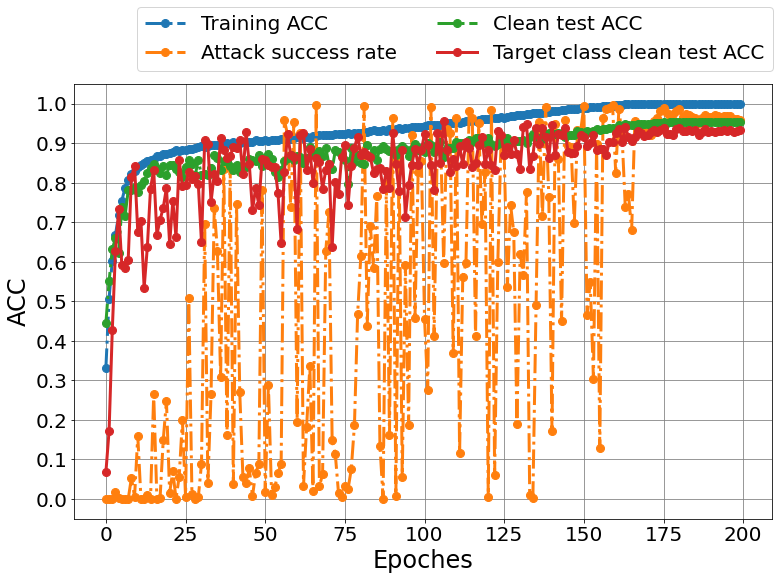

0.9999600798403194
attack 96.56666666666666
193
all class clean 95.48
target clean 93.10000000000001


In [26]:
#ours -- higher_configureations
from matplotlib import pyplot as plt
half = np.arange(0,training_epochs)
plt.figure(figsize=(12.5,8))
plt.plot(half, np.asarray(train_ACC)[half], label='Training ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(test_ACC)[half], label='Attack success rate', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(clean_ACC)[half], label='Clean test ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.plot(half, np.asarray(target_ACC)[half], label='Target class clean test ACC', linestyle="-", marker="o", linewidth=3.0, markersize = 8)
# plt.plot(half, np.asarray(test_unl_ACC)[half], label='protected test ACC', linestyle="-.", marker="o", linewidth=3.0, markersize = 8)
plt.ylabel('ACC', fontsize=24)
plt.xticks(fontsize=20)
plt.xlabel('Epoches', fontsize=24)
plt.yticks(np.arange(0,1.1, 0.1),fontsize=20)
plt.legend(fontsize=20,bbox_to_anchor=(1.016, 1.2),ncol=2)
plt.grid(color="gray", linestyle="-")
plt.show()

dis_idx = clean_ACC.index(max(clean_ACC))
print(train_ACC[dis_idx])
print('attack',test_ACC[dis_idx]*100)
print(clean_ACC.index(max(clean_ACC)))
print('all class clean', clean_ACC[dis_idx]*100)
print('target clean',target_ACC[dis_idx]*100)